# Description

*Dominik, 2017-11-27*

This file takes VGG16, changes the last layer to one with binary classification, loads the weights of a finetuned VGG16 (x layers) and can predict classes.

This file includes a variety of metrices: confusion matrix, accuracy, ROC, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import applications
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras import backend as K
K.set_image_dim_ordering('th')

import progressbar

import os

from IPython.display import Image, display, clear_output

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc

import datetime

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

Using TensorFlow backend.


In [2]:
os.chdir("/home/ubuntu/data/")

In [3]:
def get_model(top_model_weights_path, img_width, img_height):
    input_tensor = Input(shape=(3,img_width,img_height))
    base_model = applications.VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    #top_model.load_weights(top_model_weights_path)
    model = Model(inputs= base_model.input, outputs= top_model(base_model.output))
    model.load_weights(top_model_weights_path)
    return model

def predict_image_class(model, path_file, img_width,img_height):
    """returns class in binary classification.
    """
    x = load_img(path_file, target_size=(img_width,img_height))
    x = img_to_array(x)
    x = np.expand_dims(x, axis=0)
    value_prediction = model.predict(x)[0][0]
    return value_prediction

# Setting the Path
1. Take e.g. weights from: www.dominikmorgen.de/data/20171120_1519_saved_weights.h5.zip , 
2. rename the file to bottleneck_fc_model.h5 and 
3. link the path to it below in *top_model_weights_path*

In [4]:
train_data_dir = 'train'
validation_data_dir = 'validation'
test_dir = 'test'
category_array = ["Malignant", "Benign"]
img_width, img_height = 150, 150 # dimensions of our images.

def print_metrics_scatterplot(pred_array):
    plt.scatter(np.arange(0,len(pred_array[0])), pred_array[0])
    plt.show()
    plt.scatter(np.arange(0,len(pred_array[1])), pred_array[1])
    plt.show()
    return

def calc_metrics(top_model_weights_path):
    model = get_model(top_model_weights_path, img_width, img_height)
    for trainValTest in [test_dir]:
        """
        array:
        0 actual class malignant
        1 actual class benign
        """
        confusion_matrix = [[0,0],[0,0]] 
        pred_array = [[],[]]
        for a, category in enumerate(category_array):
            cur_path = trainValTest + "/" + category + "/"
            for file in os.listdir(cur_path)[:]: # progressbar.log_progress(os.listdir(cur_path)[:]):
                if file.endswith(".jpg"):
                    path_file = cur_path + file
                    value_prediction = predict_image_class(model, path_file, img_width, img_height)
                    pred_array[a] += [value_prediction]
                    if value_prediction > 0.5:
                        confusion_matrix[a][0] += 1
                    else:
                        confusion_matrix[a][1] += 1
                    
    return confusion_matrix, pred_array   

def get_scaled_accuracy(matrix):
    # values from long run 110 epochs
    # accuracy scaled = TP / (2N+) + TN / (2N-)
    matrix = np.array(matrix)
    TP = matrix[0][0]
    TN = matrix[1][1]
    N_plus = matrix[0][0] + matrix[0][1]
    N_minus = matrix[1][0] + matrix[1][1]

    acc_scaled = TP / (2*N_plus) + TN / (2*N_minus)
    return acc_scaled

def print_metrics(confusion_matrix, weight_name, flag_show_scatter=False):
    printmd("weight file: **" + str(weight_name) + "**")

    confusion_matrix = np.array(confusion_matrix)
    cm_swaped = np.swapaxes(confusion_matrix, 0, 1)
    print("{:25} {:10} {:10} {:5}".format("classified:", "malignant", "benign", "sum"))
    print("{:25} {:5} {:10} {:8}".format("actual class malignant: ",confusion_matrix[0][0],confusion_matrix[0][1],sum(cm_swaped)[0]))
    print("{:25} {:5} {:10} {:8}".format("actual class benign: ",confusion_matrix[1][0],confusion_matrix[1][1],sum(cm_swaped)[1]))

    confusion_matrix_percent = np.swapaxes( cm_swaped / sum(cm_swaped), 0, 1)
    print("{:25} {:10} {:10} {:5}".format("classified:", "malignant", "benign", "sum"))
    print("{:25} {:.2e} {:.2e} {:5}".format("actual class malignant: ",confusion_matrix_percent[0][0],confusion_matrix_percent[0][1],1))
    print("{:25} {:.2e} {:.2e} {:5}".format("actual class benign: ",confusion_matrix_percent[1][0],confusion_matrix_percent[1][1],1))
        
    TP = confusion_matrix[0][0]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    TN = confusion_matrix[1][1]
    scaled_AC = get_scaled_accuracy([[TP, FP],[FN, TN]])
    AC = (TP+TN) / (TP+FP+TN+FN)
    SE = TP / (TP+FN)
    SP = TN / (TN+FP)
    DI = (2*TP) / (2*TP + FN + FP)
    
    print("{:12} {:.3e}".format("accuracy",AC))
    string = "{:12} {:.3e}".format("scaled accuracy",scaled_AC)
    printmd("**" + string + "**")
    print("{:12} {:.3e}".format("sensitivity",SE))
    print("{:12} {:.3e}".format("specificity",SP))
    print("{:12} {:.3e}".format("dice coeff.",DI))
    
    if flag_show_scatter:
        print_metrics_scatterplot(pred_array)
        
    return

def plot_roc(pred_array, filename_prefix, dir_path):
    y_true_0 = np.ones(len(pred_array[0]))
    y_true_1 = np.zeros(len(pred_array[1]))
    y_true = np.concatenate([y_true_0, y_true_1],axis=0)
    y_score = np.concatenate(pred_array, axis=0)

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    time_now = datetime.datetime.now()
    time_string = str(time_now.hour) + str(time_now.minute)
    fileName1 = filename_prefix + "_" + time_string + "_1.png"

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(dir_path+fileName1)
    plt.show()
    return

/usr/local/lib/python3.5/dist-packages/keras/applications/vgg16.py:182: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


weight file: **4_0_10_20_2.h5**

classified:               malignant  benign     sum  
actual class malignant:       7         24       31
actual class benign:          4         83       87
classified:               malignant  benign     sum  
actual class malignant:   2.26e-01 7.74e-01     1
actual class benign:      4.60e-02 9.54e-01     1
accuracy     7.627e-01


**scaled accuracy 5.899e-01**

sensitivity  6.364e-01
specificity  7.757e-01
dice coeff.  3.333e-01


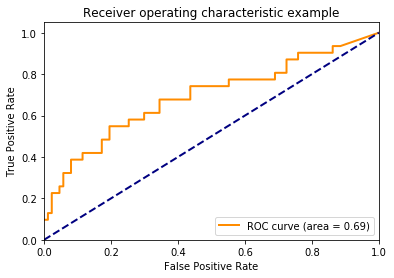

weight file: **4_0_10_20_5.h5**

classified:               malignant  benign     sum  
actual class malignant:       7         24       31
actual class benign:          3         84       87
classified:               malignant  benign     sum  
actual class malignant:   2.26e-01 7.74e-01     1
actual class benign:      3.45e-02 9.66e-01     1
accuracy     7.712e-01


**scaled accuracy 5.957e-01**

sensitivity  7.000e-01
specificity  7.778e-01
dice coeff.  3.415e-01


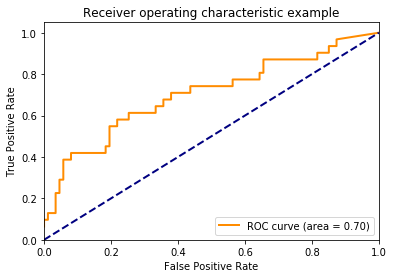

weight file: **4_1_10_20_2.h5**

classified:               malignant  benign     sum  
actual class malignant:       9         22       31
actual class benign:          5         82       87
classified:               malignant  benign     sum  
actual class malignant:   2.90e-01 7.10e-01     1
actual class benign:      5.75e-02 9.43e-01     1
accuracy     7.712e-01


**scaled accuracy 6.164e-01**

sensitivity  6.429e-01
specificity  7.885e-01
dice coeff.  4.000e-01


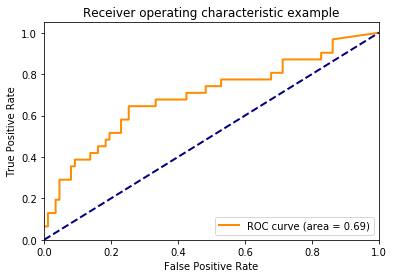

weight file: **4_2_10_20_50.h5**

classified:               malignant  benign     sum  
actual class malignant:       5         26       31
actual class benign:          2         85       87
classified:               malignant  benign     sum  
actual class malignant:   1.61e-01 8.39e-01     1
actual class benign:      2.30e-02 9.77e-01     1
accuracy     7.627e-01


**scaled accuracy 5.692e-01**

sensitivity  7.143e-01
specificity  7.658e-01
dice coeff.  2.632e-01


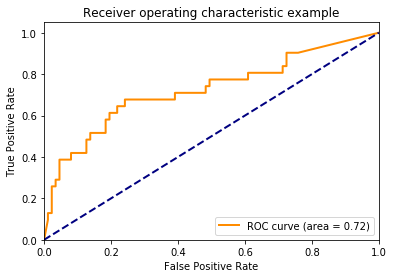

weight file: **4_1_10_20_5.h5**

classified:               malignant  benign     sum  
actual class malignant:       5         26       31
actual class benign:          2         85       87
classified:               malignant  benign     sum  
actual class malignant:   1.61e-01 8.39e-01     1
actual class benign:      2.30e-02 9.77e-01     1
accuracy     7.627e-01


**scaled accuracy 5.692e-01**

sensitivity  7.143e-01
specificity  7.658e-01
dice coeff.  2.632e-01


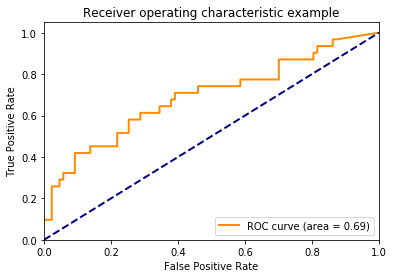

weight file: **4_0_10_20_50.h5**

classified:               malignant  benign     sum  
actual class malignant:       4         27       31
actual class benign:          1         86       87
classified:               malignant  benign     sum  
actual class malignant:   1.29e-01 8.71e-01     1
actual class benign:      1.15e-02 9.89e-01     1
accuracy     7.627e-01


**scaled accuracy 5.588e-01**

sensitivity  8.000e-01
specificity  7.611e-01
dice coeff.  2.222e-01


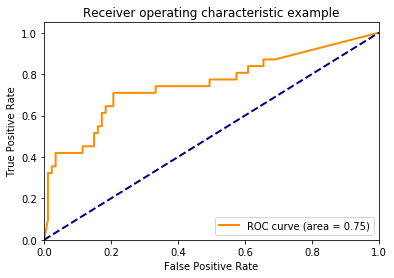

weight file: **4_1_10_20_50.h5**

classified:               malignant  benign     sum  
actual class malignant:       4         27       31
actual class benign:          1         86       87
classified:               malignant  benign     sum  
actual class malignant:   1.29e-01 8.71e-01     1
actual class benign:      1.15e-02 9.89e-01     1
accuracy     7.627e-01


**scaled accuracy 5.588e-01**

sensitivity  8.000e-01
specificity  7.611e-01
dice coeff.  2.222e-01


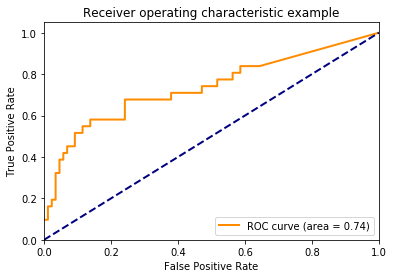

weight file: **4_2_10_20_5.h5**

classified:               malignant  benign     sum  
actual class malignant:       8         23       31
actual class benign:          3         84       87
classified:               malignant  benign     sum  
actual class malignant:   2.58e-01 7.42e-01     1
actual class benign:      3.45e-02 9.66e-01     1
accuracy     7.797e-01


**scaled accuracy 6.118e-01**

sensitivity  7.273e-01
specificity  7.850e-01
dice coeff.  3.810e-01


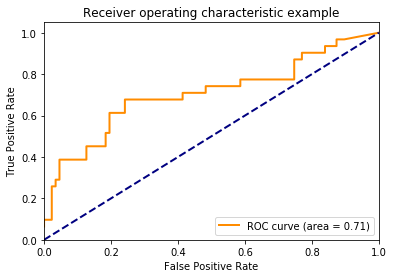

In [5]:
cur_path = "../download/"
for file in os.listdir(cur_path)[:]: # progressbar.log_progress(os.listdir(cur_path)[:]):
    if file.endswith(".h5") and file.startswith("4"):
        filepath = cur_path + file
        confusion_matrix, pred_array = calc_metrics(filepath)
        print_metrics(confusion_matrix, file)
        plot_roc(pred_array, file+"_roc", cur_path)